
前三节我们使用与房价预测相同的简单神经网络解决手写数字识别问题，效果并不理想，原因有两点：
1. 输入数据类型不同。房价预测的输入为离散一维数据。房价预测使用全连接神经网络无法学习到图像二维数据中的空间信息。
2. 模型复杂度不够。因为手写数字识别任务涉及到图像信号，比房价预测任务更加复杂，模型的复杂度也会影响最终的效果，理论上复杂的模型能够表示更复杂的转换关系（从输入到输出）。


本节介绍两种常见的网络结构，全连接神经网络和卷积神经网络，观测卷积网络能否提升手写数字识别的训练效果。

在开始介绍网络结构前，复用上一节的数据处理代码，代码如下。

In [4]:
#数据处理部分之前的代码，保持不变
import os
import random
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import gzip
import json

# 定义数据集读取器
def load_data(mode='train'):

    # 数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]

    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

## 1. 经典全连接神经网络


经典的全连接神经网络含有四层网络：两个隐含层，输入层和输出层。
- 输入层。准备数据，输入给神经网络。
- 隐含层。增加网络深度和复杂度，隐含层的节点数是可以调整的。节点数越多，神经网络表示能力越强，但同时参数量也会增加。
- 输出层。输出网络计算结果，输出层的节点数是固定的，比如手写数字识别有0-9十个数字，输出标签有10个，所以输出层必须是10个节点。

------
**说明：**

隐含层引入非线性激活函数sigmoid是为了增加神经网络的非线性能力，举例来说，一个神经网络有四个输入x1~x4，一个输出y，采用线性变换。假设第一层的变换是z1=x1-x2和z2=x3+x4，第二层的变换是y=z1+z2。将两层的变换展开后得到 y=x1-x2+x3+x4。原始输入和最终输出之间依然是线性关系，无论中间累积了多少层线性变换均是如此。

------

Sigmoid的函数曲线如下图所示，是早期神经网络模型中常见的非线性变换函数。

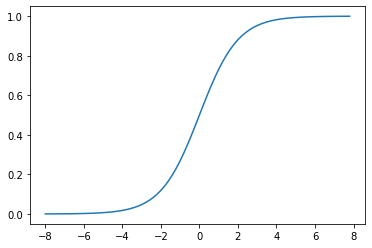

In [5]:
def sigmoid(x):
    # 直接返回sigmoid函数
    return 1. / (1. + np.exp(-x))
 
# param:起点，终点，间距
x = np.arange(-8, 8, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()


下述代码为经典全连接神经网络的实现。完成网络结构定义后，即可训练神经网络。

In [8]:
# 多层全连接神经网络实现
class MNIST(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(MNIST, self).__init__(name_scope)
        # 定义两层全连接隐含层，输出维度是10，激活函数为sigmoid
        self.fc1 = Linear(input_dim=784, output_dim=10, act='sigmoid') # 隐含层节点为10，可根据任务调整
        self.fc2 = Linear(input_dim=10, output_dim=10, act='sigmoid')
        # 定义一层全连接输出层，输出维度是1，不使用激活函数
        self.fc3 = Linear(input_dim=10, output_dim=10, act=None)
    
    # 定义网络的前向计算
    def forward(self, inputs, label=None):
        inputs = fluid.layers.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs2 = self.fc2(outputs1)
        outputs_final = self.fc3(outputs2)
        return outputs_final

In [9]:
#网络结构部分之后的代码，保持不变
with fluid.dygraph.guard():
    model = MNIST("mnist")
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置为0.01
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01, parameter_list=model.parameters())
    # 训练5轮
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            image_data, label_data = data
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
            
            #前向计算的过程
            predict = model(image)
            
            #计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    #保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [29.507156]
epoch: 0, batch: 200, loss is: [8.813838]
epoch: 0, batch: 400, loss is: [6.4828954]
epoch: 1, batch: 0, loss is: [6.6702023]
epoch: 1, batch: 200, loss is: [5.6774874]
epoch: 1, batch: 400, loss is: [3.554518]
epoch: 2, batch: 0, loss is: [4.6788864]
epoch: 2, batch: 200, loss is: [3.9420948]
epoch: 2, batch: 400, loss is: [3.681034]
epoch: 3, batch: 0, loss is: [3.5219147]
epoch: 3, batch: 200, loss is: [2.6641767]
epoch: 3, batch: 400, loss is: [3.020676]
epoch: 4, batch: 0, loss is: [2.645425]
epoch: 4, batch: 200, loss is: [3.714109]
epoch: 4, batch: 400, loss is: [3.0747201]


## 2.卷积神经网络

虽然使用经典的神经网络可以达到一定的准确率，但对于计算机视觉问题，效果最好的模型是卷积神经网络。卷积神经网络针对视觉问题的特点优化了网络结构，更适合处理视觉问题。卷积神经网络的原理会在第四章详述，在这里只展示如何将模型替换成卷积神经网络，以及它带来的效果提升。

卷积神经网络由多个卷积层和池化层组合而成，卷积层负责对输入进行扫描以生成更抽象的特征表示，而池化层则对这些特征表示进行过滤，保留最关键的信息。下面是卷积神经网络的实现，卷积和池化函数会在第四章详述，这里仅理解成一种比经典神经网络更强大的模型即可。


In [16]:
# 多层卷积神经网络实现
class MNIST(fluid.dygraph.Layer):
     def __init__(self, name_scope):
         super(MNIST, self).__init__(name_scope)
         
         # 定义卷积层，输出特征通道num_filters设置为20，卷积核的大小filter_size为5，卷积步长stride=1，padding=2
         # 激活函数使用relu
         self.conv1 = Conv2D(num_channels=1, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义池化层，池化核pool_size=2，池化步长为2，选择最大池化方式
         self.pool1 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
         # 定义卷积层，输出特征通道num_filters设置为20，卷积核的大小filter_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(num_channels=20, num_filters=20, filter_size=5, stride=1, padding=2, act='relu')
         # 定义池化层，池化核pool_size=2，池化步长为2，选择最大池化方式
         self.pool2 = Pool2D(pool_size=2, pool_stride=2, pool_type='max')
         # 定义一层全连接层，输出维度是1，不使用激活函数
         self.fc = Linear(input_dim=980, output_dim=1, act=None)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = self.pool1(x)
         x = self.conv2(x)
         x = self.pool2(x)
         x = fluid.layers.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x


接下来训练定义好的卷积神经网络，比较两个模型的损失变化（经典神经网络和卷积神经网络），可以发现卷积神经网络的损失值下降更快，且最终的损失值更小。


In [ ]:
#网络结构部分之后的代码，保持不变
with fluid.dygraph.guard():
    model = MNIST("mnist")
    model.train()
    #调用加载数据的函数
    train_loader = load_data('train')
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01, parameter_list=model.parameters())
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            image_data, label_data = data
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
             
            #前向计算的过程
            predict = model(image)
            
            #计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    #保存模型参数
    fluid.save_dygraph(model.state_dict(), 'mnist')

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [30.203884]
epoch: 0, batch: 200, loss is: [4.4081006]
epoch: 0, batch: 400, loss is: [2.1780322]
epoch: 1, batch: 0, loss is: [1.9036987]
epoch: 1, batch: 200, loss is: [2.4455953]
epoch: 1, batch: 400, loss is: [2.373762]
epoch: 2, batch: 0, loss is: [2.347315]
epoch: 2, batch: 200, loss is: [2.981688]
epoch: 2, batch: 400, loss is: [1.8106968]
epoch: 3, batch: 0, loss is: [1.282965]
epoch: 3, batch: 200, loss is: [1.3310395]
epoch: 3, batch: 400, loss is: [1.4528493]
epoch: 4, batch: 0, loss is: [1.345482]
